# Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of
money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen
credit cards, doing money laundry, etc.

Machine Learning really excels at identifying fraudulent activities. Any website where you put
your credit card information has a risk team in charge of avoiding frauds via machine learning.

The goal of this challenge is to build a machine learning model that predicts the probability that
the first transaction of a new user is fraudulent.


# Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to
perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user first transaction on the site and based on that you
have to make your classification ("fraud/no fraud").

These are the tasks you are asked to do:

* For each user, determine her country based on the numeric IP address.
* Build a model to predict whether an activity is fraudulent or not. Explain how different
assumptions about the cost of false positives vs false negatives would impact the model.
* Your boss is a bit worried about using a model she doesn't understand for something as
important as fraud detection. How would you explain her how the model is making the
predictions? Not from a mathematical perspective (she couldn't care less about that), but
from a user perspective. What kinds of users are more likely to be classified as at risk?
What are their characteristics?
* Let's say you now have this model which can be used live to predict in real time if an
activity is fraudulent or not. From a product perspective, how would you use it? That is,
what kind of different user experiences would you build based on the model output?

# Data

"Fraud_Data" - information about each user first transaction
## columns:

* user_id : Id of the user. Unique by user
* signup_time : the time when the user created her account (GMT time)
* purchase_time : the time when the user bought the item (GMT time)
* purchase_value : the cost of the item purchased (USD)
* device_id : the device id. You can assume that it is unique by device. I.e.,  transaJtions
with the same device ID means that the same physical device was used to bu`
* source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing
the site address on the browser).
* browser : the browser used by the user.
* sex : user sex: Male/Female
* age : user age
* ip_address : user numeric ip address
* class : this is what we are trying to predict: whether the activity was fraudulent (1) or not
(0).


"IpAddress_to_Country" - mapping each numeric ip address to its country.
For each country, it gives a range. If the numeric ip address falls within
the range, then the ip address belongs to the corresponding country.

## Columns:

* lower_bound_ip_address : the lower bound of the numeric ip address for that country
* upper_bound_ip_address : the upper bound of the numeric ip address for that country
* country : the corresponding country. If a user has an ip address whose value is within
the upper and lower bound, then she is based in this country.

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

fraud_data = pd.read_csv('Fraud_Data.csv')
ip_address = pd.read_csv('IpAddress_to_Country.csv')

In [148]:
# look at the data
# no null data for fraud data
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [149]:
#no null data for ip_address data
ip_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [150]:
# the ip address for fraud data have 5*10^4, but the min ip address in country table is 10^7
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [151]:
ip_address.describe()


,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [152]:
ip_address['lower_bound_ip_address'].min()

16777216.0

In [153]:
print('# of ip_address not in ip_address table:', fraud_data[fraud_data['ip_address']<=16777216].count())


# of ip_address not in ip_address table: user_id           634
signup_time       634
purchase_time     634
purchase_value    634
device_id         634
source            634
browser           634
sex               634
age               634
ip_address        634
class             634
dtype: int64


In [154]:
# the number of distinct country, only 235 country in ip_address table, but the number of data in ip_address table is 138846
unique_country = ip_address['country'].unique()
unique_country.size

235

In [155]:
ip_address.groupby('country').count()

,lower_bound_ip_address,upper_bound_ip_address
country,,
Afghanistan,46,46
Albania,56,56
Algeria,30,30
American Samoa,1,1
Andorra,5,5
...,...,...
Virgin Islands (U.S.),14,14
Wallis and Futuna Islands,2,2
Yemen,12,12


In [156]:
# look at one country, the lower bound and upper bound are quite different with each other.
ip_address[ip_address['country']=='Andorra']

,lower_bound_ip_address,upper_bound_ip_address,country
17184,1.432265e+09,1432272895,Andorra
19219,1.538998e+09,1539006463,Andorra
33427,1.836016e+09,1836023807,Andorra
53970,3.104060e+09,3104061439,Andorra
86442,3.265151e+09,3265159167,Andorra


In [157]:
unique_low_bound = ip_address['lower_bound_ip_address'].unique()
print('the number of distinct lower bound of ip address:', unique_low_bound.size)
print('the number of distinct ip address:', ip_address['country'].count())


the number of distinct lower bound of ip address: 138846
the number of distinct ip address: 138846


In [158]:
fraud_data.reset_index(inplace = True)

In [159]:
#merge ip_address table to fraud table
from pandasql import sqldf
pysql = lambda q:sqldf(q, globals())
join = '''
select f.user_id, f.signup_time, f.purchase_time, f.purchase_value, f.device_id, f.source, f.browser, f.sex, f.age, f.ip_address,
f.class, i.lower_bound_ip_address, i.upper_bound_ip_address, i.country
from fraud_data f
left join ip_address i on f.ip_address <=i.upper_bound_ip_address and f.ip_address >= i.lower_bound_ip_address
'''
fraud_join_data_1 = pysql(join)


In [160]:
# look at the merge data, the # of column is equal to the # of column in fraud data, the ip_address does not have overlap for each other
# There are have some null data for country column
fraud_join_data = fraud_join_data_1
fraud_join_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user_id                 151112 non-null  int64  
 1   signup_time             151112 non-null  object 
 2   purchase_time           151112 non-null  object 
 3   purchase_value          151112 non-null  int64  
 4   device_id               151112 non-null  object 
 5   source                  151112 non-null  object 
 6   browser                 151112 non-null  object 
 7   sex                     151112 non-null  object 
 8   age                     151112 non-null  int64  
 9   ip_address              151112 non-null  float64
 10  class                   151112 non-null  int64  
 11  lower_bound_ip_address  129146 non-null  float64
 12  upper_bound_ip_address  129146 non-null  float64
 13  country                 129146 non-null  object 
dtypes: float64(3), int64

In [161]:
fraud_join_data.describe()

,user_id,purchase_value,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000,1.291460e+05,1.291460e+05
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646,1.890950e+09,1.894646e+09
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336,1.086802e+09,1.083635e+09
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000,1.677824e+07,1.677926e+07
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000,9.395241e+08,9.563013e+08
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000,1.899708e+09,1.899733e+09
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000,2.832073e+09,2.832138e+09
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000,3.758031e+09,3.758064e+09


In [162]:
fraud_join_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,7.298089e+08,7.340032e+08,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,3.355443e+08,3.523215e+08,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2.621440e+09,2.621506e+09,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,NaN,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4.154982e+08,4.156293e+08,United States


In [163]:
#transform to datetime type
fraud_join_data['signup_time'] = pd.to_datetime(fraud_join_data.iloc[:, 1])
fraud_join_data['purchase_time'] = pd.to_datetime(fraud_join_data.iloc[:, 2])

In [164]:
fraud_join_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 151112 non-null  int64         
 1   signup_time             151112 non-null  datetime64[ns]
 2   purchase_time           151112 non-null  datetime64[ns]
 3   purchase_value          151112 non-null  int64         
 4   device_id               151112 non-null  object        
 5   source                  151112 non-null  object        
 6   browser                 151112 non-null  object        
 7   sex                     151112 non-null  object        
 8   age                     151112 non-null  int64         
 9   ip_address              151112 non-null  float64       
 10  class                   151112 non-null  int64         
 11  lower_bound_ip_address  129146 non-null  float64       
 12  upper_bound_ip_address  129146

In [165]:
fraud_join_data_country = fraud_join_data.groupby('country').count()
fraud_join_data_country_count = fraud_join_data_country['user_id']
fraud_join_data_country_count.sort_values(ascending = False)

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
                     ...  
South Sudan              1
Gambia                   1
Guadeloupe               1
Saint Martin             1
Dominica                 1
Name: user_id, Length: 181, dtype: int64

<AxesSubplot:ylabel='user_id'>

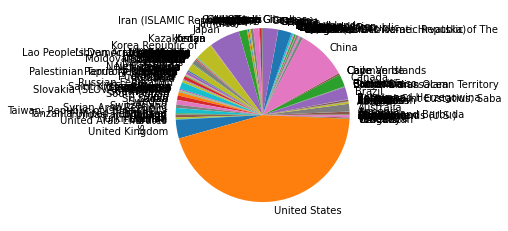

In [166]:
# from the pie plot, we can find USA, China and Japan have more proportion of transaction
fraud_join_data_country_count.plot.pie()

In [204]:
# calculate the proportion
country_proportion = fraud_join_data_country['user_id']/fraud_join_data_country['user_id'].sum()
country_proportion.sort_values(ascending = False, inplace= True)
country_proportion_cum = country_proportion.cumsum()
country_proportion_cum = country_proportion_cum.reset_index()
country_proportion_cum.head()

,country,user_id
0,United States,0.449484
1,China,0.542696
2,Japan,0.599267
3,United Kingdom,0.634034
4,Korea Republic of,0.666261


In [212]:
country_proportion_cum[country_proportion_cum['user_id']>=0.95]

,country,user_id
39,New Zealand,0.952023
40,Israel,0.954129
41,Saudi Arabia,0.956174
42,Venezuela,0.958117
43,Ireland,0.959976
...,...,...
176,South Sudan,0.999969
177,Gambia,0.999977
178,Guadeloupe,0.999985
179,Saint Martin,0.999992


Before jumping into building a model, think about whether you can create new powerful variables. This is
called feature engineering and it is the most important step in machine learning. However, feature
engineering is quite time consuming.

A few obvious variables that can be created here could be:

* Time difference between sign-up time and purchase time
* If the device id is unique or certain users are sharing the same device (many different user ids using
the same device could be an indicator of fake accounts)
* Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
* Usual week of the year and day of the week from time variables

In [168]:
#calculate the time difference between the purchase and signup
fraud_join_data['time_difference'] = fraud_join_data['purchase_time'] - fraud_join_data['signup_time']

In [169]:
fraud_join_data['time_difference'] = fraud_join_data.iloc[:,14].dt.total_seconds()

In [170]:
#check for each device id how many different user had it
device_count = fraud_join_data.groupby('device_id').count()
device_count[device_count['user_id']>2]

,user_id,signup_time,purchase_time,purchase_value,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_difference
device_id,,,,,,,,,,,,,,
AAAXXOZJRZRAO,11,11,11,11,11,11,11,11,11,11,11,11,11,11
AANYBGQSWHRTK,8,8,8,8,8,8,8,8,8,8,8,8,8,8
ADEDUDCYQMYTI,14,14,14,14,14,14,14,14,14,14,14,14,14,14
AENUQLGTUHYMS,7,7,7,7,7,7,7,7,7,7,0,0,0,7
AIGPGDVRDKOKT,12,12,12,12,12,12,12,12,12,12,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYHVSPGHWACPO,6,6,6,6,6,6,6,6,6,6,6,6,6,6
ZYZQZXBXADPST,16,16,16,16,16,16,16,16,16,16,16,16,16,16
ZZCAWCKYVMWNH,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [171]:
#check for each ip address how many different users had it
ip_account = fraud_join_data.groupby('ip_address').count()
ip_account[ip_account['user_id']>2]


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,lower_bound_ip_address,upper_bound_ip_address,country,time_difference
ip_address,,,,,,,,,,,,,,
2.278096e+06,16,16,16,16,16,16,16,16,16,16,0,0,0,16
6.150367e+06,9,9,9,9,9,9,9,9,9,9,0,0,0,9
1.666923e+07,11,11,11,11,11,11,11,11,11,11,0,0,0,11
1.819146e+07,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2.584822e+07,7,7,7,7,7,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.262695e+09,13,13,13,13,13,13,13,13,13,13,0,0,0,13
4.275223e+09,11,11,11,11,11,11,11,11,11,11,0,0,0,11
4.279796e+09,12,12,12,12,12,12,12,12,12,12,0,0,0,12


In [172]:
# day of the week
fraud_join_data['signup_time_dow'] = fraud_join_data['signup_time'].dt.dayofweek
fraud_join_data['purchase_time_dow'] = fraud_join_data['purchase_time'].dt.dayofweek

# week of year
fraud_join_data['signup_time_woy'] = fraud_join_data['signup_time'].dt.weekofyear
fraud_join_data['purchase_time_woy'] = fraud_join_data['purchase_time'].dt.weekofyear

D:\temp\ipykernel_147476\1438253378.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  fraud_join_data['signup_time_woy'] = fraud_join_data['signup_time'].dt.weekofyear
D:\temp\ipykernel_147476\1438253378.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  fraud_join_data['purchase_time_woy'] = fraud_join_data['purchase_time'].dt.weekofyear


In [173]:
fraud_join_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_difference,signup_time_dow,purchase_time_dow,signup_time_woy,purchase_time_woy
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,7.298089e+08,7.340032e+08,Japan,4506682.0,1,5,9,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,3.355443e+08,3.523215e+08,United States,17944.0,6,0,23,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2.621440e+09,2.621506e+09,United States,1.0,3,3,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,NaN,None,492085.0,1,0,18,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4.154982e+08,4.156293e+08,United States,4361461.0,1,2,30,37


In [231]:
# prepare data for model
# replace the NA country by "not found"
fraud_model_data = fraud_join_data
fraud_model_data['country'].fillna(value = "not found", inplace = True)



,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_difference,signup_time_dow,purchase_time_dow,signup_time_woy,purchase_time_woy
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,7.298089e+08,7.340032e+08,Japan,4506682.0,1,5,9,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,3.355443e+08,3.523215e+08,United States,17944.0,6,0,23,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2.621440e+09,2.621506e+09,United States,1.0,3,3,1,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,NaN,None,492085.0,1,0,18,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4.154982e+08,4.156293e+08,United States,4361461.0,1,2,30,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,3.451126e+09,3.451388e+09,United States,5261233.0,1,6,5,13
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,2.436039e+09,2.441085e+09,Netherlands,931270.0,4,1,20,22
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,2.748449e+09,2.748514e+09,Japan,6681616.0,1,2,10,21
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,3.590324e+09,3.607101e+09,United States,5146119.0,3,0,28,37


In [256]:
#drop the device id
fraud_model_data = fraud_model_data.drop(columns = ['device_id','ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address', 'user_id', 'signup_time', 'purchase_time'])


KeyError: "['device_id', 'ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address', 'user_id', 'signup_time', 'purchase_time'] not found in axis"

In [227]:
# keep the top 40 country, have more then 95% transaction contain in these 40 countries. everything else is mark as other.
replace_country = country_proportion_cum.iloc[41:,0]
for i in range(0, len(replace_country)):
    fraud_model_data['country'].replace(replace_country.iloc[i],value ='other', inplace = True)

In [258]:
#change the object type date to int
label = ['source', 'browser', 'sex', 'country']

for i in label:
   fraud_model_data[i].replace(fraud_model_data[i].unique(),range(len(fraud_model_data[i].unique())), inplace = True)

In [260]:
fraud_model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   purchase_value     151112 non-null  int64  
 1   source             151112 non-null  int64  
 2   browser            151112 non-null  int64  
 3   sex                151112 non-null  int64  
 4   age                151112 non-null  int64  
 5   class              151112 non-null  int64  
 6   country            151112 non-null  int64  
 7   time_difference    151112 non-null  float64
 8   signup_time_dow    151112 non-null  int64  
 9   purchase_time_dow  151112 non-null  int64  
 10  signup_time_woy    151112 non-null  int64  
 11  purchase_time_woy  151112 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 13.8 MB


In [266]:
# separate into train and test set
train_set, test_set =train_test_split(fraud_model_data, test_size= 0.33)
train_feature = train_set.loc[:,['purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_difference', 'signup_time_dow', 'purchase_time_dow', 'signup_time_woy', 'purchase_time_woy']]
train_class = train_set.loc[:,'class']
test_feature = test_set.loc[:,['purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_difference', 'signup_time_dow', 'purchase_time_dow', 'signup_time_woy', 'purchase_time_woy']]
test_class = test_set.loc[:,'class']

In [267]:
# random forest model
rf = RandomForestClassifier(n_estimators = 100, oob_score =  True, random_state = 20)
rf.fit(train_feature, train_class)

RandomForestClassifier(oob_score=True, random_state=20)

In [268]:
#OOB error and test error is
print('OOB error:', rf.oob_score_)

OOB error: 0.9568274976542052


Text(0.5, 0, 'Decision Tree Feature Importance')

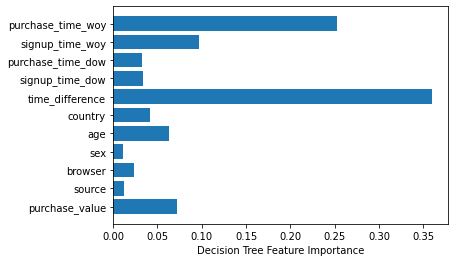

In [271]:
plt.barh(train_feature.columns, rf.feature_importances_)
plt.xlabel("Decision Tree Feature Importance")

In [269]:
# make prediction
predictions = rf.predict(test_feature)

[[45143     0]
 [ 2184  2540]]
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.769


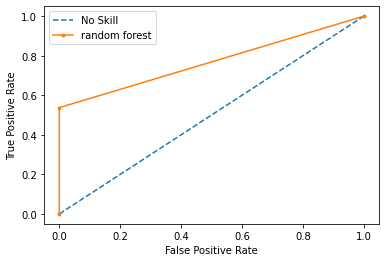

In [277]:
#calculate the confusion matrix
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(test_class, predictions)
print(conf)

#Since the challenge asks about false positive and false negative, this usually implies building the ROC and look for possible cut-off points.
from sklearn.metrics import roc_curve, roc_auc_score
ns_probs = [0 for _ in range(len(test_class))]
ns_fpr, ns_tpr, _ = roc_curve(test_class, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(test_class, predictions)
ns_auc = roc_auc_score(test_class, ns_probs)
rf_auc = roc_auc_score(test_class, predictions)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (rf_auc))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='random forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero (this was essentially the random forest
output). However, if we care about maximizing true positive, we will have to decrease the cut-off. This way
we will classify more events as “1”: some will be true ones (so true positive goes up) and many,
unfortunately, will be false ones (so false positive will also go up).

Understanding how ROC works is really important. So please review it if you are not familiar with it.
In many practical ML applications, there is no reason to use the default 0.5 cut-off value

In terms of getting insights, this is similar to the conversion rate challenge, so we won’t redo it. The most
effective strategy is again:

Look at random forest variable importance, plot partial dependence plots of the most important variables
and finally build a simple and small tree and look at the main splits.
 
Regarding “how to use this from a product perspective”: you now have a model that assigns to each user
a probability of committing a fraud. You want to think about creating different experiences based on that.
For instance:
1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall
here)
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an
additional verification step, like verify your phone number via a code sent by SMS or log in via
Facebook.
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you
can tell the user his session has been put on hold, send this user info to someone who reviews it
manually and either blocks the user or decides it is not a fraud so the session is resumed.

This is just an example and there are many different ways to build products around some fraud score.
However, it is important because it highlights that a ML model is often really useful when it is
combined with a product which is able to take advantage of its strengths and minimize its possible
drawbacks (like false positives).